In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'torchvision'

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
batch_size = 64
latent_dim = 100
image_size = 28 * 28
num_epochs = 50

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 108kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024, image_size),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(-1, image_size)
        validity = self.model(img_flat)
        return validity

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

g_losses = []
d_losses = []
real_accuracies = []
fake_accuracies = []

In [9]:
for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_real_acc = 0
    epoch_fake_acc = 0
    
    for i, (real_imgs, _) in enumerate(dataloader):
        current_batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_label = torch.ones(current_batch_size, 1).to(device)
        fake_label = torch.zeros(current_batch_size, 1).to(device)

        optimizer_G.zero_grad()
        
        z = torch.randn(current_batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(fake_imgs), real_label)
        
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        real_preds = discriminator(real_imgs)
        fake_preds = discriminator(fake_imgs.detach())

        real_loss = adversarial_loss(real_preds, real_label)
        fake_loss = adversarial_loss(fake_preds, fake_label)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()

        real_acc = ((real_preds > 0.5).float() == real_label).float().mean().item()
        fake_acc = ((fake_preds > 0.5).float() == fake_label).float().mean().item()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_real_acc += real_acc
        epoch_fake_acc += fake_acc

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                  f"[Real acc: {real_acc:.4f}] [Fake acc: {fake_acc:.4f}]")

    epoch_g_loss /= len(dataloader)
    epoch_d_loss /= len(dataloader)
    epoch_real_acc /= len(dataloader)
    epoch_fake_acc /= len(dataloader)

    g_losses.append(epoch_g_loss)
    d_losses.append(epoch_d_loss)
    real_accuracies.append(epoch_real_acc)
    fake_accuracies.append(epoch_fake_acc)

    print(f"[Epoch {epoch}/{num_epochs}] "
          f"[D loss: {epoch_d_loss:.4f}] [G loss: {epoch_g_loss:.4f}] "
          f"[D real acc: {epoch_real_acc:.4f}] [D fake acc: {epoch_fake_acc:.4f}]")

    if epoch % 5 == 0:
        with torch.no_grad():
            sample_z = torch.randn(25, latent_dim).to(device)
            gen_imgs = generator(sample_z).cpu().detach()

            fig, axs = plt.subplots(5, 5, figsize=(10, 10))
            for ax_i, ax in enumerate(axs.flat):
                ax.imshow(gen_imgs[ax_i, 0].numpy(), cmap='gray')
                ax.axis('off')
            plt.savefig(f"gan_generated_epoch_{epoch}.png")
            plt.close()

print("Training completed!")

[Epoch 0/50] [Batch 0/938] [D loss: 0.6918] [G loss: 0.6726] [Real acc: 0.8438] [Fake acc: 0.1250]
[Epoch 0/50] [Batch 100/938] [D loss: 0.1047] [G loss: 1.9454] [Real acc: 1.0000] [Fake acc: 1.0000]
[Epoch 0/50] [Batch 200/938] [D loss: 0.2889] [G loss: 1.1091] [Real acc: 1.0000] [Fake acc: 0.7500]
[Epoch 0/50] [Batch 300/938] [D loss: 0.5779] [G loss: 0.4621] [Real acc: 1.0000] [Fake acc: 0.0625]
[Epoch 0/50] [Batch 400/938] [D loss: 0.5401] [G loss: 0.8907] [Real acc: 0.8594] [Fake acc: 1.0000]
[Epoch 0/50] [Batch 500/938] [D loss: 0.7536] [G loss: 0.3303] [Real acc: 0.9688] [Fake acc: 0.0000]
[Epoch 0/50] [Batch 600/938] [D loss: 0.6467] [G loss: 0.5576] [Real acc: 0.9062] [Fake acc: 0.0156]
[Epoch 0/50] [Batch 700/938] [D loss: 0.5992] [G loss: 0.7460] [Real acc: 0.8281] [Fake acc: 0.6094]
[Epoch 0/50] [Batch 800/938] [D loss: 0.5892] [G loss: 0.7184] [Real acc: 0.8750] [Fake acc: 0.6719]
[Epoch 0/50] [Batch 900/938] [D loss: 0.6586] [G loss: 1.1842] [Real acc: 0.1719] [Fake acc: 

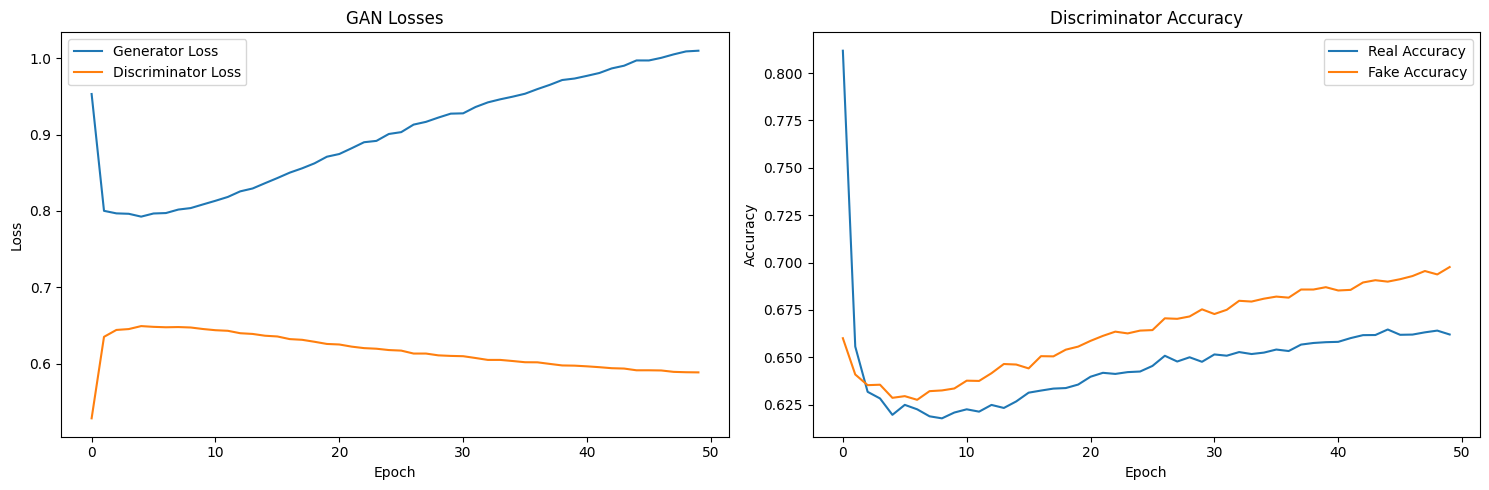

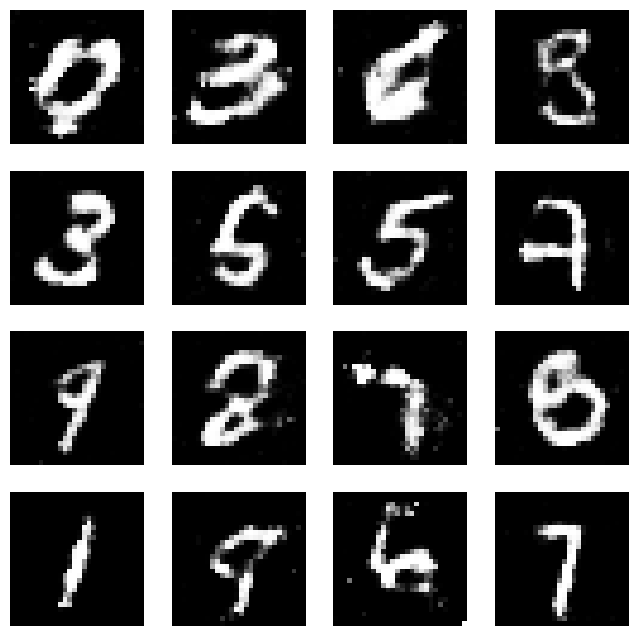

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('GAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(real_accuracies, label='Real Accuracy')
plt.plot(fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("gan_training_metrics.png")
plt.show()

with torch.no_grad():
    sample_z = torch.randn(16, latent_dim).to(device)
    gen_imgs = generator(sample_z).cpu().detach()

    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for ax_i, ax in enumerate(axs.flat):
        ax.imshow(gen_imgs[ax_i, 0].numpy(), cmap='gray')
        ax.axis('off')
    plt.savefig("final_gan_generated.png")
    plt.show()

torch.save(generator.state_dict(), "gan_generator.pth")
torch.save(discriminator.state_dict(), "gan_discriminator.pth")